In [1]:
import os, sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from dataset import IRMASDataset, collate_fn
from utils import get_wav_files, CLASSES
from transforms import PreprocessPipeline, RandomCombine, LabelsFromTxt, OneHotEncode, ParentMultilabel, PreprocessPipelineRNN
from torch.utils.data import Dataset, DataLoader
import torchaudio
import IPython.display as ipd
from torch.nn.utils.rnn import pad_sequence
from models import RNN
from train import train_loop
import torchvision.transforms

import matplotlib.pyplot as plt
import numpy as np

/home/912c2e22633dde2e/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [8]:
preprocess = PreprocessPipelineRNN(target_sr=22050)
transforms = torchvision.transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=2560, hop_length=512),
    torchaudio.transforms.AmplitudeToDB(stype="power", top_db=90)
])
target_transforms = torchvision.transforms.Compose([
    ParentMultilabel(sep=" "),
    OneHotEncode(CLASSES)
])

data_dir = os.path.join(Path(os.getcwd()).parent, "data/raw/IRMAS_Training_Data")
train_dst = IRMASDataset(data_dir, preprocess=preprocess, transforms=transforms, target_transforms=target_transforms)

train_dl = DataLoader(train_dst, batch_size=8, collate_fn=collate_fn, shuffle=True, pin_memory=True, num_workers=16)

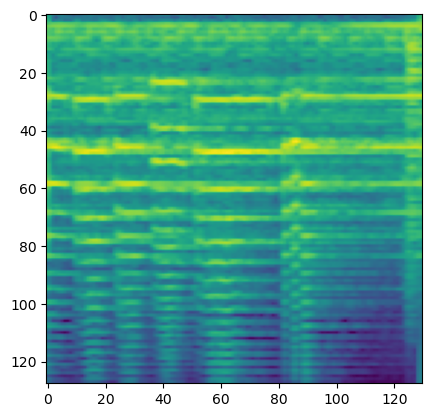

In [9]:
spec = train_dst[0][0].squeeze()
plt.imshow(spec)

In [10]:
model = RNN(128,64,3,11, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

In [11]:
class FocalLoss(nn.Module):

    def __init__(self, alpha=0.25, gamma=2, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
    
    def forward(self, inputs, targets):
        p = torch.sigmoid(inputs)
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none", pos_weight=self.pos_weight)
        p_t = p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)
        
        return loss.mean()

In [16]:
train_loop(train_dl, model, optimizer, FocalLoss(pos_weight=torch.tensor([10]).repeat(11).cuda()), device)

100%|█████████████████████████████| 839/839 [00:09<00:00, 92.70it/s, loss=0.172]
